In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Hospital Overflow and Unmet Care Simulation and Analysis

This notebook presents a simulation and subsequent analysis of hospital overflow and unmet care needs over a specified period. The simulation models patient arrivals, hospital capacity, and the resulting overflow and unmet care statistics.

- The implementation sets up a SIXHRD compartmental model with hospital capacity contraints.

- It uses Euler's method to simulate the system with a time step of ```dt``` over a period of ```Tmax``` days.

- It implements the smooth Hill function for modeling hospital admission gating.

- It tracks key metrics such as total overflow and unmet care needs.

- It includes vaccine effects using a leaky model when coverage $\gt 0$.
- It visualizes the results of the epidemic dynamics, hospital capacity utilization, overflow, and summary statistics.

In [3]:
# Parameters
beta = 0.5          # transmission rate
sigma = 0.2         # progression rate from I to X (needs care)
eta = 0.3           # hospitalization rate from X
gamma_I = 0.1       # recovery rate from I
mu_I = 0.01         # mortality rate from I
gamma_X = 0.15      # recovery rate from X
mu_X = 0.05         # mortality rate from X
gamma_H = 0.2       # recovery rate from H
mu_H = 0.02         # mortality rate from H
theta_X = 0.5       # relative infectiousness of X
theta_H = 0.3       # relative infectiousness of H
K = 100             # hospital capacity
n = 4               # Hill coefficient (sharpness)

# Vaccine parameters (optional)
coverage = 0.0      # vaccine coverage
VE = 0.7            # vaccine efficacy

# Initial conditions
N = 10000           # total population
S = N - 10
I = 10
X = 0
H = 0
R = 0
D = 0

# Simulation parameters
Tmax = 200          # days
dt = 0.1            # time step

# Storage arrays
times = []
S_vals, I_vals, X_vals, H_vals, R_vals, D_vals = [], [], [], [], [], []
overflow_vals = []
cum_overflow = 0
cum_unmet = 0

# Simulation loop
t = 0
while t <= Tmax:
    # Store current state
    times.append(t)
    S_vals.append(S)
    I_vals.append(I)
    X_vals.append(X)
    H_vals.append(H)
    R_vals.append(R)
    D_vals.append(D)
    
    # Vaccine leaky option
    eff_beta = beta * (1 - coverage * VE)
    
    # Force of infection
    lambda_foi = eff_beta * (I + theta_X*X + theta_H*H) / N
    new_inf = lambda_foi * S
    
    # Capacity gate (smooth Hill function)
    g = 1 / (1 + (H/K)**n)
    admit = eta * X * g
    
    # Differential equations
    dS = -new_inf
    dI = new_inf - (gamma_I + mu_I + sigma) * I
    dX = sigma*I - (gamma_X + mu_X) * X - admit
    dH = admit - (gamma_H + mu_H) * H
    dR = gamma_I*I + gamma_X*X + gamma_H*H
    dD = mu_I*I + mu_X*X + mu_H*H
    
    # Euler update
    S += dS * dt
    I += dI * dt
    X += dX * dt
    H += dH * dt
    R += dR * dt
    D += dD * dt
    
    # Track metrics
    overflow = max(0, H - K)
    cum_overflow += overflow * dt
    overflow_vals.append(overflow)
    unmet_care = eta*X - admit
    cum_unmet += max(0, unmet_care) * dt
    
    t += dt



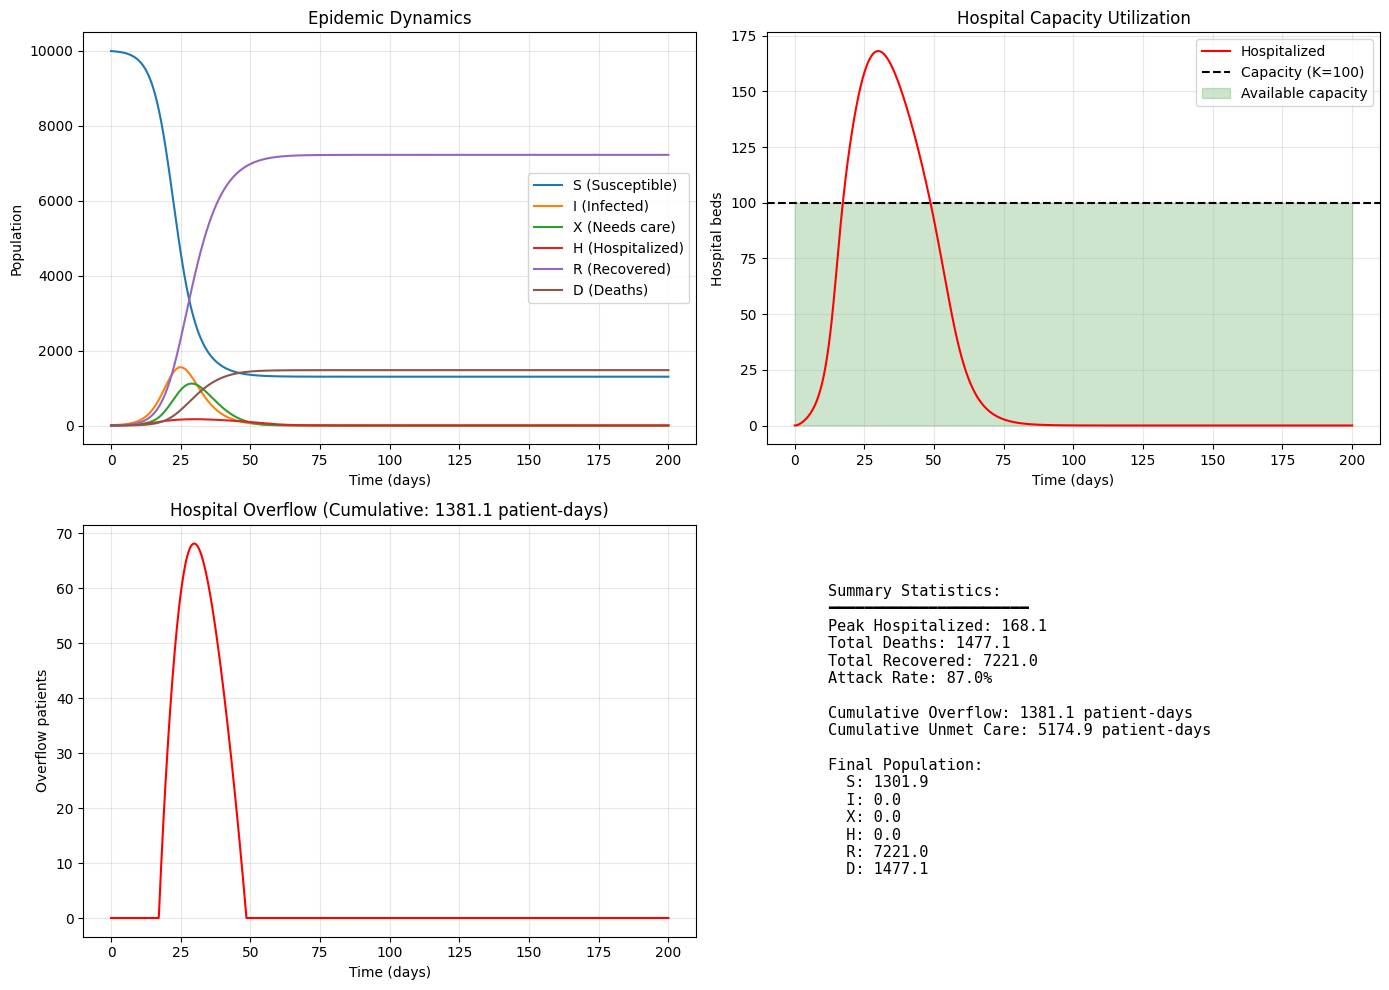


Simulation complete!
Total deaths: 1477
Peak hospital occupancy: 168.1 (Capacity: 100)
Cumulative overflow: 1381.1 patient-days


In [4]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Compartments over time
axes[0, 0].plot(times, S_vals, label='S (Susceptible)')
axes[0, 0].plot(times, I_vals, label='I (Infected)')
axes[0, 0].plot(times, X_vals, label='X (Needs care)')
axes[0, 0].plot(times, H_vals, label='H (Hospitalized)')
axes[0, 0].plot(times, R_vals, label='R (Recovered)')
axes[0, 0].plot(times, D_vals, label='D (Deaths)')
axes[0, 0].set_xlabel('Time (days)')
axes[0, 0].set_ylabel('Population')
axes[0, 0].legend()
axes[0, 0].set_title('Epidemic Dynamics')
axes[0, 0].grid(True, alpha=0.3)

# Hospital capacity
axes[0, 1].plot(times, H_vals, label='Hospitalized', color='red')
axes[0, 1].axhline(y=K, color='black', linestyle='--', label=f'Capacity (K={K})')
axes[0, 1].fill_between(times, 0, K, alpha=0.2, color='green', label='Available capacity')
axes[0, 1].set_xlabel('Time (days)')
axes[0, 1].set_ylabel('Hospital beds')
axes[0, 1].legend()
axes[0, 1].set_title('Hospital Capacity Utilization')
axes[0, 1].grid(True, alpha=0.3)

# Overflow
axes[1, 0].plot(times, overflow_vals, color='red')
axes[1, 0].set_xlabel('Time (days)')
axes[1, 0].set_ylabel('Overflow patients')
axes[1, 0].set_title(f'Hospital Overflow (Cumulative: {cum_overflow:.1f} patient-days)')
axes[1, 0].grid(True, alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Summary Statistics:
━━━━━━━━━━━━━━━━━━━━━━
Peak Hospitalized: {max(H_vals):.1f}
Total Deaths: {D_vals[-1]:.1f}
Total Recovered: {R_vals[-1]:.1f}
Attack Rate: {((I_vals[-1] + X_vals[-1] + H_vals[-1] + R_vals[-1] + D_vals[-1]) / N * 100):.1f}%

Cumulative Overflow: {cum_overflow:.1f} patient-days
Cumulative Unmet Care: {cum_unmet:.1f} patient-days

Final Population:
  S: {S_vals[-1]:.1f}
  I: {I_vals[-1]:.1f}
  X: {X_vals[-1]:.1f}
  H: {H_vals[-1]:.1f}
  R: {R_vals[-1]:.1f}
  D: {D_vals[-1]:.1f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
                verticalalignment='center')

plt.tight_layout()
plt.show()

print(f"\nSimulation complete!")
print(f"Total deaths: {D_vals[-1]:.0f}")
print(f"Peak hospital occupancy: {max(H_vals):.1f} (Capacity: {K})")
print(f"Cumulative overflow: {cum_overflow:.1f} patient-days")